In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from pathlib import Path

folder = ""
project_dir = "02_cnn_tf"

base_path = Path("/content/drive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive/02_cnn_tf


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import check_util.checker as checker
from IPython.display import clear_output
from PIL import Image

import os
import time
import re
from glob import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers

print('tensorflow version: {}'.format(tf.__version__))
print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


tensorflow version: 2.17.0
GPU 사용 가능 여부: False


In [ ]:
import zipfile
from pathlib import Path

current_path = Path().absolute()
data_path = current_path / "data"
print("현재 디렉토리 위치: {}".format(current_path))
if (data_path / "my_cat_dog").exists():
    print("이미 'data/my_cat_dog' 폴더에 압축이 풀려있습니다. 확인해보세요!")
else:
    with zipfile.ZipFile(str(data_path / "my_cat_dog.zip"), "r") as zip_ref:
        zip_ref.extractall(str(data_path / "my_cat_dog"))
    print("Done!")

현재 디렉토리 위치: /content/drive/My Drive/02_cnn_tf
이미 'data/my_cat_dog' 폴더에 압축이 풀려있습니다. 확인해보세요!


In [ ]:
data_dir = './data/my_cat_dog'  # 압축 해제된 데이터셋의 디렉토리 경로

In [ ]:
checker.dataset_check(data_dir)

훈련용 고양이 이미지 개수: 1000
훈련용 강아지 이미지 개수: 1000
검증용 고양이 이미지 개수: 500
검증용 강아지 이미지 개수: 500
테스트용 고양이 이미지 개수: 1000
테스트용 강아지 이미지 개수: 1000
dataset이 제대로 구성되어 있습니다! 이어서 진행하셔도 좋습니다.


In [ ]:
print_steps = 1
val_epoch = 1

batch_size = 20
max_epochs = 10
learning_rate = 1e-4
IMG_SIZE = 150

PATH = data_dir

In [ ]:
def load(image_file, label):
    # 해당경로의 파일을 읽어서 float 타입으로 변환합니다.
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)

    return image, label

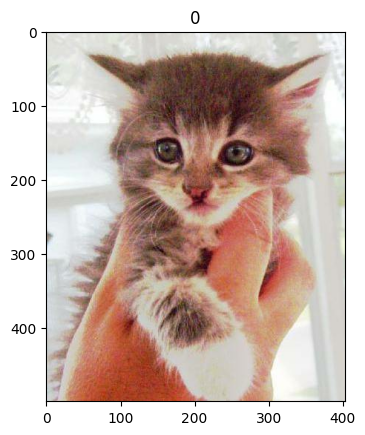

In [ ]:
image, label = load(os.path.join(PATH, 'train/cat/cat.100.jpg'), 0)
# casting to int for matplotlib to show the image
plt.figure()
plt.title(label)
plt.imshow(image/255.0)
plt.show()

In [ ]:
def resize(input_image, height, width):

    input_image = tf.image.resize(input_image, [height, width])

    return input_image

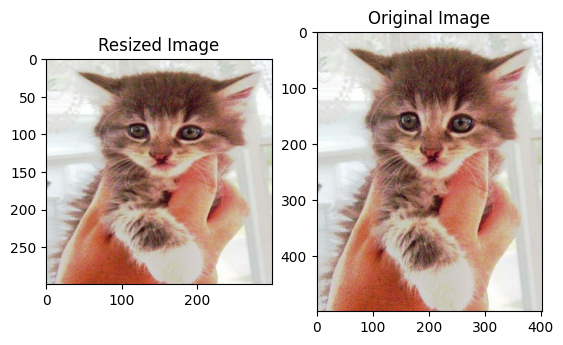

In [ ]:
plt.figure()
plt.subplot(121)
plt.title("Resized Image")
plt.imshow(resize(image, 300, 300)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [ ]:
def random_rotation(input_image):

    angles = np.random.randint(0, 4)
    rotated_image = tf.image.rot90(input_image, k=angles)

    return rotated_image

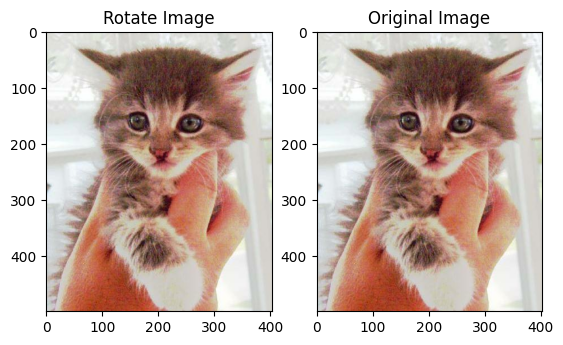

In [ ]:
plt.figure()
plt.subplot(121)
plt.title("Rotate Image")
plt.imshow(random_rotation(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [ ]:
def random_crop(input_image):

    cropped_image = tf.image.random_crop(input_image, size=[150,150,3])

    return cropped_image

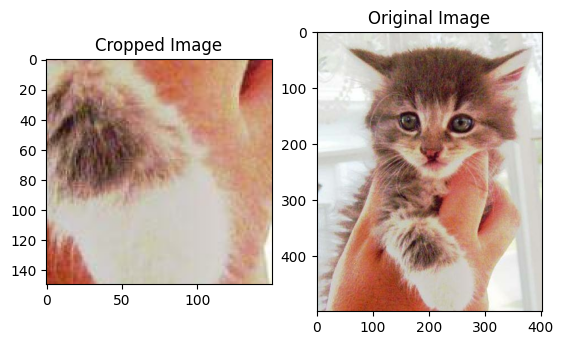

In [ ]:
plt.figure()
plt.subplot(121)
plt.title("Cropped Image")
plt.imshow(random_crop(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [ ]:
# normalizing the images to [-1, 1]
def normalize(input_image):
    # 이미지 픽셀값의 범위를 normalize 합니다. [0, 255] -> [-1, 1]

    input_image = input_image / 127.5 - 1.0

    return input_image

In [ ]:
def random_jitter(input_image):

    # resizing to 176 x 176 x 3
    input_image = resize(input_image, height=176, width=176)
    # randomly cropping to 150 x 150 x 3
    input_image = random_crop(input_image)
    # randomly rotation
    input_image = random_rotation(input_image)
    # randomly mirroring
    input_image = tf.image.random_flip_left_right(input_image)

    return input_image

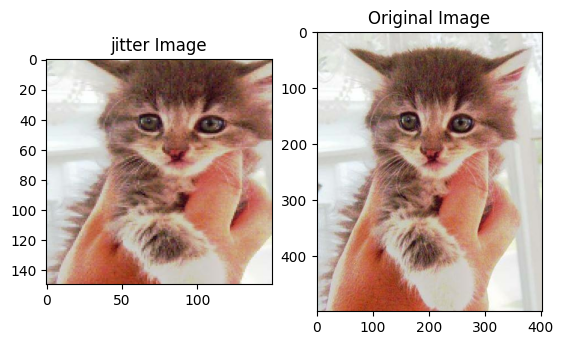

In [ ]:
plt.figure()
plt.subplot(121)
plt.title("jitter Image")
plt.imshow(random_jitter(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [ ]:
def central_crop(input_image):
    # 176 x 176 으로 resize후 150 x 150 중앙 crop 합니다.

    # resizing to 176 x 176 x 3
    input_image = resize(input_image, height=176, width=176)
    # central cropping to 150 x 150 x 3
    central_fraction = 150 / 176
    input_image = tf.image.central_crop(input_image, central_fraction = central_fraction)

    return input_image

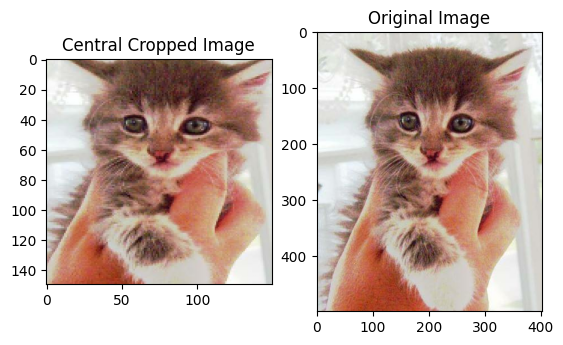

In [ ]:
plt.figure()
plt.subplot(121)
plt.title("Central Cropped Image")
plt.imshow(central_crop(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [ ]:
def load_image_train(image_file, label):

    input_image, label = load(image_file, label)
    input_image = random_jitter(input_image)
    input_image = normalize(input_image)

    return input_image, label

In [ ]:
def load_image_val_and_test(image_file, label):

    input_image, label = load(image_file, label)
    input_image = random_jitter(input_image)
    input_image = normalize(input_image)

    return input_image, label

In [ ]:
def add_label(image_file, label):
    return image_file, label

In [ ]:
# train folder에 있는 폴더 이름을 list로 나타냅니다.
# 즉 학습에 사용할 category의 이름을 list로 나타내는 것입니다.
folder_list = [f for f in os.listdir(os.path.join(PATH, 'train')) if not f.startswith('.')]

In [ ]:
train_dataset = tf.data.Dataset.list_files(                            # 1번
    os.path.join(PATH, 'train', folder_list[0], '*.jpg'))
train_dataset = train_dataset.map(lambda x: add_label(x, 0))          # 2번
for label, category_name in enumerate(folder_list[1:], 1):            # 3번
    temp_dataset = tf.data.Dataset.list_files(                         # 4번
        os.path.join(PATH, 'train', category_name, '*.jpg'))
    temp_dataset = temp_dataset.map(lambda x: add_label(x, label))    # 5번
    train_dataset = train_dataset.concatenate(temp_dataset)            # 6번

In [ ]:
N = BUFFER_SIZE = len(list(train_dataset)) # number of samples in train_dataset
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=16)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()

In [ ]:
folder_list = [f for f in os.listdir(os.path.join(PATH, 'val')) if not f.startswith('.')]
val_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'val', folder_list[0], '*.jpg'))
val_dataset = val_dataset.map(lambda x: add_label(x, 0))
for label, category_name in enumerate(folder_list[1:], 1):
    temp_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'val', category_name, '*.jpg'))
    temp_dataset = temp_dataset.map(lambda x: add_label(x, label))
    val_dataset = val_dataset.concatenate(temp_dataset)

val_dataset = val_dataset.map(load_image_val_and_test)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.repeat()

In [ ]:
folder_list = [f for f in os.listdir(os.path.join(PATH, 'test')) if not f.startswith('.')]
test_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'test', folder_list[0], '*.jpg'))
test_dataset = test_dataset.map(lambda x: add_label(x, 0))
for label, category_name in enumerate(folder_list[1:], 1):
    temp_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'test', category_name, '*.jpg'))
    temp_dataset = temp_dataset.map(lambda x: add_label(x, label))
    test_dataset = test_dataset.concatenate(temp_dataset)

test_dataset = test_dataset.map(load_image_val_and_test)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

In [ ]:
for images, labels in train_dataset.take(1):
    for j in range(20):
        plt.figure()
        plt.imshow(images[j])
        plt.title(labels[j].numpy())
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
class Conv(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(Conv, self).__init__()

        self.conv = tf.keras.layers.Conv2D(filters, kernel_size)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.pool = tf.keras.layers.MaxPool2D()

    def call(self, inputs, training=True):

        x = self.conv(inputs)   # self.conv forward
        x = self.bn(x)    # self.bn   forward
        x = self.relu(x)   # self.relu forward
        x = self.pool(x)    # self.pool forward

        return x

In [ ]:
model = tf.keras.Sequential()

model.add(Conv(filters= 32, kernel_size= 3))
model.add(Conv(filters= 64, kernel_size= 3))
model.add(Conv(filters= 128, kernel_size= 3))
model.add(Conv(filters= 128, kernel_size= 3))

model.add(tf.keras.layers.Flatten())  # flatten
model.add(tf.keras.layers.Dense(512, activation='relu'))  # relu
model.add(tf.keras.layers.Dense(2, activation='softmax'))  # softmax

In [ ]:
model(images[:1])

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.24636835, 0.7536316 ]], dtype=float32)>

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv (Conv)                          │ (1, 74, 74, 32)             │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv)                        │ (1, 36, 36, 64)             │          18,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv)                        │ (1, 17, 17, 128)            │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv)                        │ (1, 7, 7, 128)              │         148,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (1, 6272)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 512)                    │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 2)                      │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,455,042 (13.18 MB)

 Trainable params: 3,454,338 (13.18 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
checkpoint_path = "./train/exp_cnn/cp-{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq='epoch',  verbose=1)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
train_len = len(glob(os.path.join(PATH, 'train', folder_list[0], '*.jpg'))) * 2
val_len = len(glob(os.path.join(PATH, 'val', folder_list[0], '*.jpg'))) * 2
test_len = len(glob(os.path.join(PATH, 'test', folder_list[0], '*.jpg'))) * 2

In [ ]:
model.fit(train_dataset, steps_per_epoch = train_len // batch_size,
          validation_data= val_dataset,
          validation_steps= val_len // batch_size,
         epochs= 10,
         callbacks= [cp_callback])

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6124 - loss: 0.6864
Epoch 1: saving model to ./train/exp_cnn/cp-0001.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 436s 4s/step - accuracy: 0.6127 - loss: 0.6860 - val_accuracy: 0.5010 - val_loss: 0.9502
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7020 - loss: 0.5909
Epoch 2: saving model to ./train/exp_cnn/cp-0002.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.7017 - loss: 0.5911 - val_accuracy: 0.6250 - val_loss: 0.6420
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7451 - loss: 0.5450
Epoch 3: saving model to ./train/exp_cnn/cp-0003.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.7450 - loss: 0.5451 - val_accuracy: 0.6370 - val_loss: 0.6264
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7174 - loss: 0.5673
Epoch 4: saving model to ./train/exp_cnn/cp-0004.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.7172 - los

In [ ]:
model = tf.keras.Sequential()

model.add(Conv(filters= 32, kernel_size= 3))
model.add(Conv(filters= 64, kernel_size= 3))
model.add(Conv(filters= 128, kernel_size= 3))
model.add(Conv(filters= 128, kernel_size= 3))

model.add(tf.keras.layers.Flatten())  # flatten
model.add(tf.keras.layers.Dense(512, activation='relu'))  # relu
model.add(tf.keras.layers.Dense(2, activation='softmax'))  # softmax

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

# inputs을 넣어 모델 생성
for images, labels in train_dataset.take(1):
    outputs = model(images, training=False)

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

In [ ]:
if latest:
    model.load_weights(latest)
    print("Model weights loaded from:", latest)
else:
    print("No checkpoint file found.")

No checkpoint file found.


In [ ]:
model.load_weights(latest)

ValueError: File format not supported: filepath=None. Keras 3 only supports V3 `.keras` and `.weights.h5` files, or legacy V1/V2 `.h5` files.

In [ ]:
model.evaluate(test_dataset, steps=test_len//batch_size)

100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4991 - loss: 0.6997


[0.6992226839065552, 0.5]

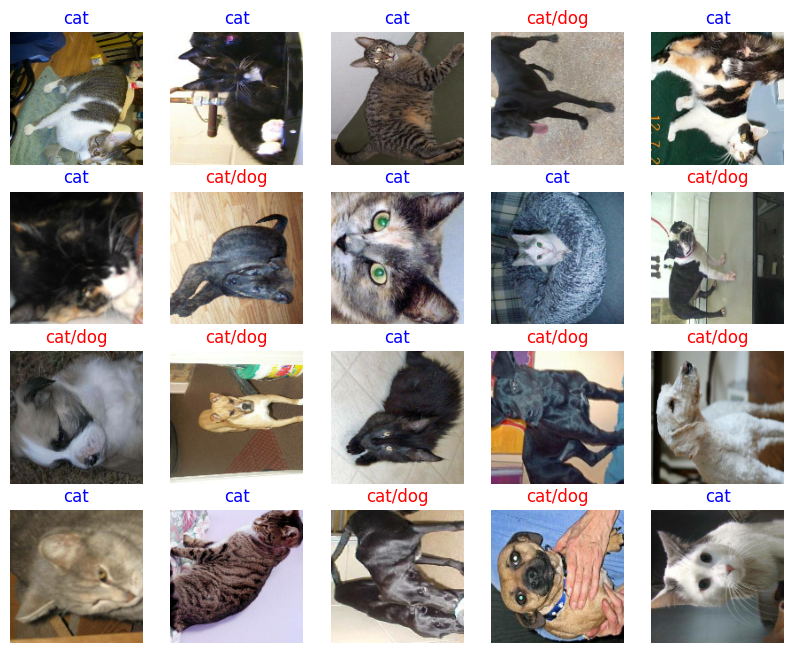

In [ ]:
test_batch_size = 25

for images, labels in test_dataset.take(1):
    predictions = model(images)

images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

labels_map = {0: 'cat', 1: 'dog'}

# 시각화
fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(images, labels, predictions)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred.numpy()) == py.numpy():
        p.set_title("{}".format(labels_map[py.numpy()]), color='blue')
    else:
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred.numpy())],
                                   labels_map[py.numpy()]), color='red')
    p.imshow(px.numpy()*0.5+0.5)
    p.axis('off')

In [ ]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        include_top=False,
                                        input_shape=(IMG_SIZE, IMG_SIZE, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = tf.keras.Sequential()
model.add(conv_base)
model.add(layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation = 'relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [ ]:
# training variable 확인
for var in model.trainable_variables:
    print(var.name)

kernel
bias
kernel
bias
kernel
bias
kernel
bias
kernel
bias
kernel
bias
kernel
bias
kernel
bias
kernel
bias
kernel
bias
kernel
bias
kernel
bias
kernel
bias


In [ ]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
# training variable 확인
for var in model.trainable_variables:
    print(var.name)

kernel
bias
kernel
bias
kernel
bias


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
checkpoint_path = "./train/exp_pre_trained/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq='epoch',  verbose=1)

ValueError: When using `save_weights_only=True` in `ModelCheckpoint`, the filepath provided must end in `.weights.h5` (Keras weights format). Received: filepath=./train/exp_pre_trained/cp.ckpt

In [ ]:
model.fit(train_dataset, steps_per_epoch = train_len//batch_size,
          validation_data= val_dataset,
          validation_steps= val_len//batch_size,
          epochs= 5,
          callbacks= [cp_callback])

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7179 - loss: 0.5580
Epoch 1: saving model to ./train/exp_cnn/cp-0001.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 164ms/step - accuracy: 0.7187 - loss: 0.5568 - val_accuracy: 0.7260 - val_loss: 0.6605
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9143 - loss: 0.2234
Epoch 2: saving model to ./train/exp_cnn/cp-0002.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.9143 - loss: 0.2234 - val_accuracy: 0.8150 - val_loss: 0.3890
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9375 - loss: 0.1616
Epoch 3: saving model to ./train/exp_cnn/cp-0003.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.9375 - loss: 0.1617 - val_accuracy: 0.7980 - val_loss: 0.4801
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9693 - loss: 0.0905
Epoch 4: saving model to ./train/exp_cnn/cp-0004.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 

In [ ]:
model = tf.keras.Sequential()
model.add(conv_base)
model.add(layers.Flatten())

# 코드 시작
model.add(tf.keras.layers.Dense(256, activation = 'relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])
# 코드 종료

In [ ]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

ValueError: File format not supported: filepath=./train/exp_pre_trained/cp.ckpt. Keras 3 only supports V3 `.keras` and `.weights.h5` files, or legacy V1/V2 `.h5` files.

In [ ]:
model.evaluate(test_dataset, steps= test_len/batch_size)

TypeError: 'float' object cannot be interpreted as an integer

- Dataset class를 우리가 가진 데이터셋에 맞게 customize 하여 정의할 수 있다.
- CNN을 설계하고 이미지 분류기를 학습시킬 수 있다.
- 학습된 모델을 저장하고 불러올 수 있다.
- 데이터, 리소스, 시간이 부족한 상황에서 전이학습을 사용하여 이를 극복할 수 있다.

---